# ランダム行列でのSpectral Form Factor(SFF)の計算

In [1]:
##### パッケージの読み込み #####
using LinearAlgebra  #線形代数パッケージ
using Plots  #プロット用パッケージ
using Statistics  #mean関数
using Distributions  #rand関数, Normal関数
using ProgressMeter  #進捗バー表示
using FLoops  #forループの並列化

GUE型アンサンブルのランダム行列はエルミート行列であり、各要素は\
平均:$\mu=0$, 標準偏差:$\sigma=\frac{1}{\sqrt{L}}$\
のガウス分布(正規分布)からランダムに選ばれる。

In [8]:
##### 複素エルミートランダム行列の生成 #####
function rand_M(L)
    M=zeros(ComplexF64,L,L)  #L×L行列(配列)の用意
    for i in 1:L
        for j in 1:L
            #各要素:M_ijにガウス分布に従う乱数を代入
            M[i,j]=Distributions.rand(Normal(0,1/sqrt(L)))+im*Distributions.rand(Normal(0,1/sqrt(L)))
        end
    end
    return (M+M')/2  #エルミート化
end

rand_M (generic function with 1 method)

\begin{equation}
\mathrm{SFF} : g(t;\beta)=\left|\frac{Z(\beta+it)}{Z(\beta)}\right|^2,
\quad Z(\beta+it)=\mathrm{Tr}\left(e^{-\beta H-iHt}\right),
\quad Z(\beta)=\mathrm{Tr}\left(e^{-\beta H}\right)
\end{equation}

In [3]:
##### |Z(β+it)|^2 #####
function SFF_u(e,β,t)
    Z_t=sum(exp.(-(β+im*t)*e))
    return Z_t*Z_t'
end

##### Z(β) #####
function get_Z(e,β)
    Z=sum(exp.(-β*e))
    return Z
end

get_Z (generic function with 1 method)

In [4]:
############# SET UP ##############
L=256;         #行列のサイズ
samples=120;   #サンプリング数
β=5;            #逆温度
###################################

In [5]:
##### 時間軸 #####
ts = exp10.(range(-1,stop=5,length=10000));   #t=[10^-1,10^5], 10000等分

g_u=zeros(Float64,(samples,length(ts)));
g_d=zeros(Float64,samples);

In [6]:
##### SFFの分母,分子をそれぞれsamples回計算して配列に代入 #####
function calc_g()
    prog=Progress(samples,1);
    @floop for  i=1:samples  #　@floopでループを並列化
        M=rand_M(L);  #ランダム行列を生成
        e=eigvals!(M);  #ランダム行列の固有値を計算
        g_d[i]=get_Z(e,β);  # Z(β)
        @inbounds for (j,t) in enumerate(ts)
            g_u[i,j]=SFF_u(e,β,t);  # |Z(β+it)|^2
        end
        next!(prog)
    end
end
calc_g()

##### 平均 <...> を取る #####
g_u_mean=mean(g_u,dims=1);  # <Z(β+it)*Z(β-it)>
g_d_mean=(mean(g_d))^2;  # <Z(β)>^2
gs_mean=g_u_mean/g_d_mean;  # g(t;β) = <|Z(β,t)|^2> / <Z(β)>^2

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


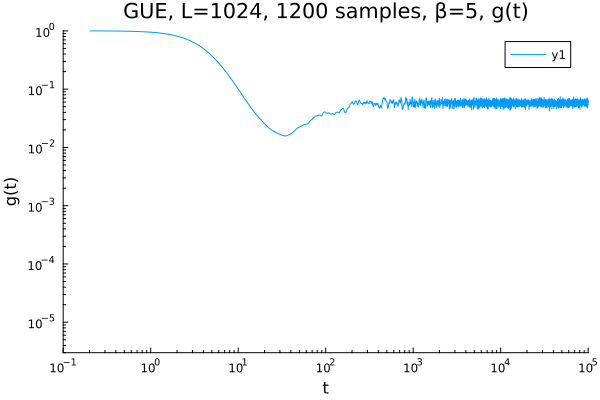

In [7]:
##### プロット #####
p=plot(ts,gs_mean[:],xaxis=:log,yaxis=:log,xlims=(0.1,10^5),ylims=(3*10^-6,1),
    xticks=[0.1,1,10,10^2,10^3,10^4,10^5],yticks=[10^-5,10^-4,10^-3,10^-2,10^-1,1],
    xlabel="t",ylabel="g(t)",title="GUE, L=1024, 1200 samples, β=5, g(t)",
    minorticks=true,xgrid=false,ygrid=false)

In [ ]:
##### プロットをPDFで保存 #####
savefig(p,"SFF.pdf")

In [ ]:
################## (ts, gs_mean[:]) プロット用データをtxt形式で保存 ##################
out=open("data_L=$L"*"_$samples"*"samples.txt","w") # ~.txtを作成して開く
println(out,"ts, gs_mean")
Base.print_array(out,hcat(ts,gs_mean[:])) #(ts, gs_mean)を2列にして保存
close(out) #ファイルを閉じる